In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/repos/nanoOpt.jl/Project.toml`


In [25]:
using Images, FFTW,LazyGrids,CoordinateTransformations ,Plots; pyplot()

Plots.PyPlotBackend()

In [3]:
include("../src/NanoOpt.jl")

efieldC (generic function with 1 method)

In [4]:
methods(dipole)

# 1 method for type constructor:
[1] dipole(material::MaterialParams, k₀::Number, pos, dip) in Main at /home/martinez/Documents/repos/nanoOpt.jl/src/Material.jl:49

In [5]:
λ = 650
k₀ = 2π/λ

mat1 = material(1.33^2,1.0)
mat2 = material(1.0,1.0);

k = mat1.k(k₀);

In [6]:
k

0.012856363782382847

In [7]:
image = load("micron.png") .|> Gray

image = Float64.(1.0 .-image);

nx,ny = size(image)

scale = 7

x,y = ((1:nx) .- 0.5*nx)*scale, ((1:ny) .- 0.5*ny)*scale;

In [8]:
dip1 = [0.,0.,1.]
pos = [0.,0.,-10.]
dip = dipole(mat1,k₀,pos,dip1);

In [9]:
p = dip
npad = 2

2

# Electric field

In [10]:
 e = eplane(p,x,y, npad, 0.0);

In [11]:
f,_ = fourier2(x,y,image,npad*nx,npad*ny)
ie,_ = fourier2(x,y,e,npad*nx,npad*ny);

In [12]:
ie[:,:,1] = ie[:,:,1] .* f
ie[:,:,2] = ie[:,:,2] .* f
ie[:,:,3] = ie[:,:,3] .* f;

In [13]:
e0 = ifourier2(x,y,ie);

In [14]:
angular = Angular(x,y,e0, mat1, k₀,1,npad);

In [15]:
plotsZ = []

zArr = [0,20,50,100]

for z ∈ zArr
    e = efieldC(angular,z);
    Ef = real(sum(conj.(e) .* e,dims=3))[:,:,1]
    p = heatmap(sqrt.(Ef),yflip=true,xlabel="X [nm]",ylabel="Y [nm]",title="z="*string(z)*"nm", colorbar=:none)
    push!(plotsZ,p)
end

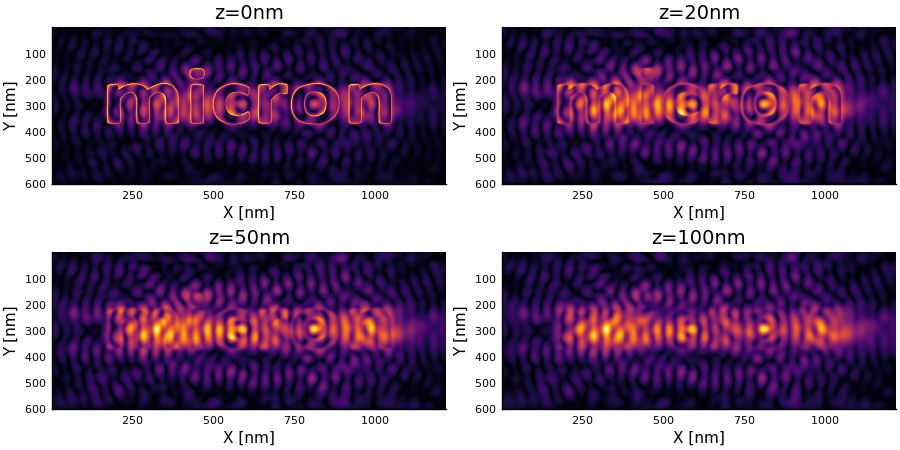

In [16]:
plot(plotsZ...,size=(900,450))

## Lens Image far field

In [17]:
struct far <: Field
    k0::Number
    kx::Vector{Number}
    ky::Vector{Number}
    x::Vector{Number}
    y::Vector{Number}
    far::Array{ComplexF64, 3}
    
    function far(angular::Angular)
        kz= angular.kvec[3]
        ind = findall(imag(kz[:]) .!= 0.0)
        ind2 = findall(imag(kz[:]) .== 0.0)

        farf = reshape(angular.iefield,(:,3))
        farf[ind,:] .= 0.0*im

        farf = -im*2π*kz.*reshape(farf,(size(angular.iefield)))
        
        new(angular.k0,angular.kx,angular.ky,angular.x,angular.y,farf)
    end
end

In [18]:
struct lensimage2 <: Field
    ang1::Angular
    mat1::MaterialParams
    mat2::MaterialParams
    k0::Number
    NA::Number
    
    function lensimage2(angular::Angular,mat2::MaterialParams,NA::Number)
       new(angular,angular.mat,mat2,angular.k0,NA) 
    end
end

In [157]:
function waveselect(kvec,n,NA)
    kvec = [reshape(kvec[1],(:,1)) reshape(kvec[2],(:,1)) reshape(kvec[3],(:,1))]
    k = sqrt(real(sum(kvec[1,:].^2)))
    kz = kvec[:,3]
    ind = findall(imag(kz) .== 0)

    if n !=0
        sint = NA/n
        cost = kz ./ k
        ind  = findall((real.(1 .-cost.^2) .< sint ^ 2).&(imag(kz) .== 0))
    end

    dir = kvec[ind,:] /k
    
    return(ind,dir)
end

function cart2sph(x,y,z)
    ρ = sqrt(x^2+y^2+z^2)
    θ = acos(z/ρ)
    ϕ = atan(y/x)
    
    return (ρ,θ,ϕ)
end

function cart2unit(vec::Matrix{Number})
    siz = size(vec)
    vec = reshape(vec,(:,3))
    vec = real.(vec)
    sphVec = zeros(size(vec,1),2)
    for i in axes(sphVec,1)
        _,sphVec[i,1],sphVec[i,2] = cart2sph(x,y,z)
    end

    θ,ϕ = sphVec[:,1],sphVec[:,2];
    θ = π/2 .- θ
    
    sinθ, cosθ = sin.(θ),cos.(θ)
    sinϕ, cosϕ = sin.(ϕ),cos.(ϕ)
    uϕ = [-sinϕ cosϕ 0*ϕ]
    ur = [cosϕ sinϕ 0*ϕ]
    uθ = [cosϕ.*cosθ sinϕ.*cosθ -sinθ]
    
    return (uϕ,uθ,ur,ϕ,θ)
end

function unitproject(x,u1)
    sum(x.*u1, dims=ndims(x))
end

function unitproject(x,u1,u2)
    y = sum(x.*u1, dims=ndims(x))
    u2.*y
end

unitproject (generic function with 2 methods)

In [144]:
fl = far(angular)
NA = 1.0
lens=lensimage2(angular,mat2,NA);
farf = fl.far;

In [145]:
n1,n2 = lens.mat1.n(lens.k0),lens.mat2.n(lens.k0)
k1,k2 = lens.mat1.k(lens.k0),lens.mat2.k(lens.k0)

kx,ky = lens.ang1.kx,lens.ang1.ky;

kx,ky = ndgrid(kx,ky);

kz = sqrt.(Complex.(k1^2 .- kx.^2 .- ky.^2 ))

ind,_ = waveselect([Complex.(kx),Complex.(ky),kz],n1,NA);

In [146]:
siz = size(farf)
farf = reshape(farf,(:,3))
farf,kx,ky,kz = farf[ind,:],kx[ind],ky[ind],kz[ind];

In [147]:
uϕ,uθ,ur,_,θ = cart2unit(hcat(kx,ky,kz));

In [155]:
xw = farf
u1 = uϕ
u2 = uθ

1061×3 Matrix{Float64}:
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 ⋮                   
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784
 0.267261  0.534522  -0.801784

In [156]:
yt = sum(xw.*u1, dims=ndims(xw))

u2.*yt

1061×3 Matrix{ComplexF64}:
   -0.367029-0.0681027im     -0.734058-0.136205im      1.10109+0.204308im
   -0.478452-0.0637628im     -0.956904-0.127526im      1.43536+0.191289im
   -0.570907-0.0662584im      -1.14181-0.132517im      1.71272+0.198775im
  -0.0737321-0.0371083im     -0.147464-0.0742165im    0.221196+0.111325im
   -0.138859-0.0447142im     -0.277718-0.0894285im    0.416577+0.134143im
    -0.22532-0.0464299im     -0.450639-0.0928598im    0.675959+0.13929im
   -0.325916-0.0482984im     -0.651832-0.0965968im    0.977749+0.144895im
   -0.425831-0.0562773im     -0.851661-0.112555im      1.27749+0.168832im
   -0.505785-0.0717983im      -1.01157-0.143597im      1.51736+0.215395im
   -0.547773-0.0904669im      -1.09555-0.180934im      1.64332+0.271401im
   -0.541263-0.104103im       -1.08253-0.208205im      1.62379+0.312308im
   -0.487179-0.104709im      -0.974359-0.209417im      1.46154+0.314126im
 -0.00787067+0.000905206im  -0.0157413+0.00181041im   0.023612-0.00271562im
          

In [152]:
typeof(xw)

Matrix{ComplexF64} (alias for Array{Complex{Float64}, 2})

In [134]:
?ndims

search: ndims CylindricalFromSpherical CylindricalFromCartesian



```
ndims(A::AbstractArray) -> Integer
```

Return the number of dimensions of `A`.

# Examples

```jldoctest
julia> A = fill(1, (3,4,5));

julia> ndims(A)
3
```
